## Model Evaluation

One of the problems when trying to build prediction models with geograpich data is that we can not assume that the data are independent. Data points that are closer geographically usually are also more similar than those further away. This phenomennon is called Spatial autocorrelation (SAC). 

Spatial Autocorrelation (SAC) and its effects on spatial data analysis has been extensively studied in spatial statistics literature, e.g. (Legendre 1993, Koenig 1999).  

### Spatial Cross-Validation (SKCV)

Due to SAC the traditional Cross-Validation is not appropiate to evaluate the predictive performance of models that are based on geographic data. It has been demostrated that normal Cross-Validation would generate optimistically biased performance results.

There are several methods to account for SAC described in the literature (Dormann et al, 2007). For this project the method we are going to use to tackle the problem of the Spatial Autocorrelation (SAC) is the method described in the works of (Pohjankukka et al. 2017), where the authors propose a new modified version of the CV method called spatial k-fold cross validation (SKCV), which provides a useful estimate for model prediction performance without optimistic bias due to SAC.

<img src="files/SKCV.png" width="360">


The spatial k-fold cross validation (SKCV) consist on a modified leave-one-out cross-validation in which on each fold we remove from the training set those data points that are closer to the sample we are testing. To achieve that we fix a radius (geographic distance) from the sample, removing those data points that reside inside that radius. 

SKCV prevent the effect of SAC, providing the performance value as a function of the distance between known data and unknown data.

<img src="files/Pseudo Code SKCV.png" width="600">


#### REFERENCES

Dormann, F., et al., 2007. Methods to account for spatial autocorrelation in the analysis
of species distributional data: a review. Ecography, 30 (5), 609{628.

Koenig, W.D., 1999. Spatial autocorrelation of ecological phenomena. Trends in Ecology
& Evolution, 14 (1), 22{26.

Legendre, P., 1993. Spatial Autocorrelation: Trouble or New Paradigm?. Ecology, 74 (6),
1659{1673.

Pohjankukka, J., et al., 2017. Estimating the Prediction Performance of Spatial Models
via Spatial k-Fold Cross Validation. International Journal of Geographical Information Science, 31(10), 1-19.




### Cooncordance Index (C-Index)
The scoring I am going to use to evaluate the performance of the model is the cooncordance index (c-index). The C-index is a performance measure that indicates how well the model captures the relative ordering/ranking of the data points. It is calculated using the predicted values together with the true values.

- C-index does not measure the absolute accuracy of the model’s predictions when compared with the true labels.

- C-index measures how well the model was able to rank the data points into correct order.

- C-index is measured from 0 to 1, with 0.5 meaning the model wasn’t able to capture any information from the data.

<img src="files/C-Index Pseudo Code.png" width="600">


#### C-index implementation:

In [9]:
def c_index(true_labels, predictions):
    """ Calculates the concordance index (C-index) """

    true_labels = list(true_labels)
    predictions = list(predictions)

    n = 0
    h_sum = 0
    for i in range(len(true_labels)):
        t = true_labels[i]
        p = predictions[i]
        for j in range(i + 1, len(true_labels)):
            nt = true_labels[j]
            np = predictions[j]
            if t != nt:
                n += 1
                if (p < np and t < nt) or (p > np and t > nt):
                    h_sum += 1
                elif p == np:
                    h_sum += 0.5
    # To avoid 'ZeroDivisionError' exception
    if n == 0:
        return h_sum
    return h_sum / n

### Spatial Cross-Validation (SKCV) Implementation

In [34]:
from math import sqrt

# Function to calculate the geographic distance
def get_geographical_distance(coordinates_1, coordinates_2):
    """ Calculate the geographic distance between 2 pair of coordinates """
    x1, y1 = coordinates_1
    x2, y2 = coordinates_2
    distance = sqrt(((x1 - x2) ** 2) + ((y1 - y2) ** 2))

    return distance


# SKCV implementation
def spatial_cross_validation(*, model, X, y, scoring, radius=0, verbose=True):
   
    """ Spatial cross-validation (SKCV)

     Args:
        - model: Sklearn based prediction model.
        - X : Features (x_coordinates and y_coordinates columns required); (pandas.DataFrame).
        - y: Target (pandas.Series or list).
        - radious: Deadzone radius in meters (default=0).
        - scoring: callable scoring function.
        - verbose: If True, running info will be printed to the console.
    Returns:
        - Dict ('score', 'predictions')
           
    """ 

    dead_zone_radius = radius  # Deadzone radius in meters
    X = X.copy()
    y = y.copy()

    # Set scoring function
    scoring = scoring

    y_df = pd.DataFrame(y, columns=['target'])
    df = pd.concat([X, y_df], axis=1)

    predictions = []
    for index, sample in df.iterrows():
        sample_xy = (sample['coordinate_x'], sample['coordinate_y'])

        # Calculate geographic distances
        if radius != 0:
            df['distance'] = df.apply(
                lambda x: get_geographical_distance(sample_xy, (x['coordinate_x'], x['coordinate_y'])),
                axis=1)
            # Remove from the training data set the samples that are inside dead_zone_distance
            df_cleaned = df[df['distance'] > dead_zone_radius]

            X_train = df_cleaned.drop(['coordinate_x', 'coordinate_y', 'distance', 'target'], axis=1)

        else:
            # If radius==0 drop only the sample present in the test set
            df_cleaned = df.drop(index)
            X_train = df_cleaned.drop(['coordinate_x', 'coordinate_y', 'target'], axis=1)

        y_train = df_cleaned['target']
        X_test = sample.drop(['coordinate_x', 'coordinate_y', 'target'])
        X_test = np.array(X_test).reshape(1, -1)

        # Make prediction
        pred = model.fit(X_train, y_train).predict(X_test)
        predictions.append(pred[0])

    # Evaluate predictions
    score = scoring(y, predictions)
    if verbose:
        print(f"\nScore: {score}\n")

    dict_results = {'score': score, 'predictions': predictions}

    return dict_results


##### Let's also implement a normal leave_one_out cross-validation so that we can compare the performance resutls with the SKCV.

In [1]:
import random

def leave_n_out_cv(*, model, X, y, n_out=10, scoring, verbose=True):
    """ Leave-n-out Cross-validation"""
    
    model = model
    X = X.copy()
    y = y.copy()

    if not isinstance(y, pd.DataFrame):
        y = pd.DataFrame(y, columns=['target'])
    else:
        y.columns = ['target']

    df = pd.concat([X, y], axis=1)

    scoring_func = scoring

    indexes = list(X.index.values)
    random.Random(4).shuffle(indexes)

    n_out = n_out

    if len(X) % n_out == 0:
        number_of_samples = int(len(X) / n_out)
    else:
        number_of_samples = int((len(X) // n_out) + 1)

    predictions = {'y_test': [], 'y_pred': []}
    end_loop = False
    while not end_loop:

        for i in range(number_of_samples):

            # Check how many indexes are left
            if len(indexes) <= n_out:
                # Put the remaining items in the sample and leave the loop run only 1 time more
                sample = indexes
                end_loop = True  # This will stop the loop on the next round

            else:
                sample = [indexes.pop(0) for i in range(n_out)]

            train = df.drop(sample)
            X_train = train.drop(['target'], axis=1)
            y_train = train['target']
            X_test = df.loc[sample].drop(['target'], axis=1)
            y_test = df.loc[sample]['target']

            # Reshape X_test and y_test is they are a single sample
            if len(X) == 1:
                X_test = np.array(X_test).reshape(1, -1)

            y_pred = model.fit(X_train, y_train).predict(X_test)

            predictions['y_test'].append(list(y_test))
            predictions['y_pred'].append(list(y_pred))


    score = scoring_func(predictions['y_test'], predictions['y_pred'])

    if verbose:
        print(f"Score ({scoring_func.__name__}): {score}", "\n")

    results_dict = {
        "score": score,
        "predictions": predictions
    }
    return results_dict

#### Let's compare both cross-validations

In [2]:
# Import data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

input_data = pd.read_csv(r'knn_model\data\INPUT.csv', header=None)
coordinates = pd.read_csv(r'knn_model\data\COORDINATES.csv', header=None)
coordinates.columns = ['c_x', 'c_y']
X = pd.concat([input_data, coordinates], axis=1)

# Standardization
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

y = pd.read_csv(r'knn_model\data\OUTPUT.csv', header=None)
y.columns = ['target']
y = y['target'].values


#### Normal leave-one-out cross-validation

In [217]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=37, metric='euclidean')

loocv_results = leave_n_out_cv(model=knn, X=X, y=y, n_out=1, scoring=c_index)

Score (c_index): 0.7219005528264987 



#### Spatial cross-validation (SKCV)

In [218]:
# This columns will be use to calculate the geographic distance in the SKCV 
coordinates.columns = ['coordinate_x', 'coordinate_y']
X = pd.concat([X, coordinates], axis=1)

In [219]:
radius = [r for r in range(0, 201, 10)]

scores = {}
for r in radius:
    skcv_results = spatial_cross_validation(model=knn, X=X, y=y, scoring=c_index, radius=r, verbose=False)
    print(f"Radius: {r} - Score (c_index): {skcv_results['score']}")
          
    # Save score in dict
    scores[r] = skcv_results['score']    

Radius: 0 - Score (c_index): 0.7219005528264987
Radius: 10 - Score (c_index): 0.7167369657398761
Radius: 20 - Score (c_index): 0.715903666237826
Radius: 30 - Score (c_index): 0.7108734210706831
Radius: 40 - Score (c_index): 0.7064339401032298
Radius: 50 - Score (c_index): 0.6970979058669045
Radius: 60 - Score (c_index): 0.6885983209417509
Radius: 70 - Score (c_index): 0.6809152365366659
Radius: 80 - Score (c_index): 0.674472826946687
Radius: 90 - Score (c_index): 0.6719785281011971
Radius: 100 - Score (c_index): 0.667046276995614
Radius: 110 - Score (c_index): 0.6271546444285476
Radius: 120 - Score (c_index): 0.6105894482794343
Radius: 130 - Score (c_index): 0.6016747885078164
Radius: 140 - Score (c_index): 0.5989894012422847
Radius: 150 - Score (c_index): 0.5962319183457483
Radius: 160 - Score (c_index): 0.5964681540298657
Radius: 170 - Score (c_index): 0.5960296306043854
Radius: 180 - Score (c_index): 0.5961612226299087
Radius: 190 - Score (c_index): 0.5955918071364875
Radius: 200 - 

#### Let's plot the results of the SKCV

Text(0.5, 1.0, 'c-index vs dead zone radius')

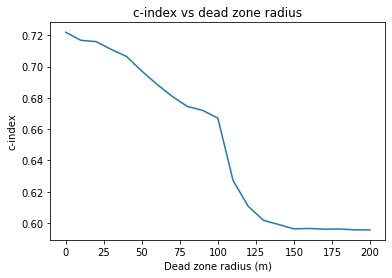

In [222]:
import seaborn as sns

scores = pd.DataFrame(pd.Series(scores)).reset_index()
scores.columns = ['Dead zone radius (m)', 'c-index']

sns.lineplot(y='c-index', x='Dead zone radius (m)', data=scores, markers=True).set_title('c-index vs dead zone radius')

As it was to expect we can observe how the performance of our model decreases significanly as we increase the deadzone radius.

### Spatial Cross-Validation Optimized

Due to the high numbers of features the current running time of the spatial_cross_validation function is quite high:

In [69]:
from timeit import default_timer as timer

start = timer()
spatial_cross_validation(model=knn, X=X, y=y, scoring=c_index, radius=10, verbose=False)
end = timer()
print(f"Running time: {end - start} s")

Running time: 115.46517100000347 s


With a running time of almost 2 minutes if we want to search for the optimum numbers of neighbors, lets say from n_neighbors=1 to n_neighbors=40, it would take 1 hour and 20 minutes (spects: 16Gb RAM; i7 core). However, we can create a new Spatial Cross-Validation implementation optimized for k Nearest Neighbors that reuses the distances for each of the different n_neighbors instead of re-calculating them again.

#### spatial_CV_knn_optimized implementation

In [76]:
from statistics import mean

def spatial_CV_knn_optimized(*, model, X, y, radius=0, scoring, n_neighbors=5, verbose=True):

    """ Spatial cross-validation knn optimized(SKCV)

     Args:
        - model: sklearn.neighbors model (either for regression or classification)
        - X : Features (x_coordinates and y_coordinates columns required); (pandas.DataFrame).
        - y: Target (pandas.Series, list).
        - radious: Deadzone radius in meters (default=0).
        - scoring: callable scoring function.
        - n_neighbors: number of neighbors (integer, list of integers)
        - verbose: If True, running info will be printed to the console.
    Returns:
        - Pandas.DataFrame
           
    """ 

    assert isinstance(X, pd.DataFrame), f"X: DataFrame type expected (Given: {type(X)})"
    assert isinstance(y, pd.Series) or isinstance(X, list), f"y: Series/list type expected " \
                                                            f"(Given: {type(y)})"

    dead_zone_radius = radius  # Distance in meters
    X = X.copy()
    y = y.copy()

    # Convert to a list if it is not a list
    if not isinstance(n_neighbors, list):
        n_neighbors = [n_neighbors]
    else:
        n_neighbors = n_neighbors

    # Create DataFrame to store the predictions
    df_predictions = pd.DataFrame([[None for n in n_neighbors] for i in range(len(X))])
    df_predictions.columns = [n for n in n_neighbors]

    # Create DataFrame to store the scoring results and predictions for each value of n_neighbors
    df_results = pd.DataFrame([None, None] for n in n_neighbors)
    df_results.columns = ['score', 'predictions']
    df_results.index = [n for n in n_neighbors]
    df_results.index.name = 'n_neighbours'

    # The kneighbours() method of the sklearn.kneighbors models returns a matrix where
    # each row is the indexes in X of the n_neighbors sorted in order of proximity to the
    # same sample/row in X.

    numberOfNeighbors = len(X) - 1  # We want to return all of the neighbors

    # We must drop the geographic coordinates when fitting the model
    model.fit(X.drop(['coordinate_x', 'coordinate_y'], axis=1), y)
    neighbors_matrix = model.kneighbors(n_neighbors=numberOfNeighbors, return_distance=False)

    # Now we have a matrix with the indexes of all the neighbours of each sample in ordered by proximity.
    # However, this matrix contains also those data points that are inside the dead zone radius.
    # To apply spatial leave-one-out cross-validation we need to find out which are the indexes of those data points
    # that are inside the dead zone so we can ignore them:
    for index, sample in X.iterrows():

        if radius != 0:
            # Get coordinates of the current sample
            sample_xy = (sample['coordinate_x'], sample['coordinate_y'])

            # Calculate geographic distances from each data point to the current sample
            X['distance'] = X.apply(
                lambda x: get_geographical_distance(sample_xy, (x['coordinate_x'], x['coordinate_y'])),
                axis=1)
            # Get indexes of the data points that are inside the dead zone radius
            inside = X[X['distance'] <= dead_zone_radius]
            indexesToIgnore = list(inside.index.values)
        else:
            indexesToIgnore = []

        # Get the list of neighbors of the current sample.
        neighbors = neighbors_matrix[index]

        # Get the indexes of the k nearest neighbours ignoring those inside the dead zone radius
        neighbors_indexes = []
        pointer = 0
        while len(neighbors_indexes) < max(n_neighbors):
            neighbor_index = neighbors[pointer]
            if neighbor_index in indexesToIgnore:
                pointer += 1
            else:
                neighbors_indexes.append(neighbor_index)
                pointer += 1

        # Make a prediction for each of the n_neighbors values
        for n in n_neighbors:
            df_predictions.loc[index][n] = mean([y[neighbor_index] for neighbor_index in neighbors_indexes[:n]])

    # Score the predictions
    for n in n_neighbors:
        y_pred = df_predictions[n].values
        score = scoring(y, y_pred)
        df_results.loc[n]['score'] = score
        df_results.loc[n]['predictions'] = y_pred

        if verbose:
            print(f"Neighbors: {n} - Score: {score}")

    return df_results

#### Comparing both implementations:

In [78]:
from timeit import default_timer as timer

n_neighbors = [2, 3, 4, 5, 6]


# Normal SKCV
start = timer()
for n in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=n, metric='euclidean')
    spatial_cross_validation(model=knn, X=X, y=y, scoring=c_index, radius=10, verbose=False)
end = timer()
print(f"Normal SKCV: {end - start} s")

# kNN Optimized SKCV:
start = timer()
knn = KNeighborsRegressor(metric='euclidean')
spatial_CV_knn_optimized(model=knn, X=X, y=pd.Series(y), radius=10, scoring=c_index, n_neighbors=n_neighbors, verbose=False)
end = timer()
print(f"Optimized SKCV: {end - start} s")

Normal SKCV: 507.8381410999864 s
Optimized SKCV: 89.30317490000743 s


With the normal SKCV function the Time Complexity of the algorithm when testing k different values for n_neighbors was O(n*k), while the Time Complexity of the algorithm when using the optimized SKCV function is O(n). This means that we can test the  performance of our kNN model with as many different number of neighbours as we want without increasing the execution time.

### Random-leave-out (SKCV-RLO)

One important aspect that we have not taken into account until now is how much of the decrease in performance in the SKCV is just caused by the decreased size of the training set. As described in (Pohjankukka et al. 2017) a easy way to measure that effect is to implement a random-leave-out (SKCV-RLO). SKCV-RLO is identical to the SKCV method with the exception that instead of removing data points from the training set that are inside the dead zone perimeter, we instead remove the same number of data points randomly from the training set as we would remove in SKCV (Pohjankukka et al. 2017).


#### SKCV-RLO implementation:

In [131]:
# SKCV-RLO implementation
def random_leave_out_cv(*, model, X, y, scoring, radius=0, verbose=True):
   
    dead_zone_radius = radius  # Deadzone radius in meters
    X = X.copy()
    y = y.copy()

    # Set scoring function
    scoring = scoring

    y_df = pd.DataFrame(y, columns=['target'])
    df = pd.concat([X, y_df], axis=1)

    predictions = []
    for index, sample in df.iterrows():
        sample_xy = (sample['coordinate_x'], sample['coordinate_y'])

        # Calculate geographic distances
        if radius != 0:
            df['distance'] = df.apply(
                lambda x: get_geographical_distance(sample_xy, (x['coordinate_x'], x['coordinate_y'])), axis=1)
            
            # Train size
            train_size = len(df[df['distance'] > dead_zone_radius])
            
            df_train = df.drop(index)
            df_train = df_train.sample(n=train_size, random_state=0)
            
            X_train = df_train.drop(['coordinate_x', 'coordinate_y', 'distance', 'target'], axis=1)

        else:
            # If radius==0 drop only the sample present in the test set
            df_train = df.drop(index)
            X_train = df_train.drop(['coordinate_x', 'coordinate_y', 'target'], axis=1)

        y_train = df_train['target']
        X_test = sample.drop(['coordinate_x', 'coordinate_y', 'target'])
        X_test = np.array(X_test).reshape(1, -1)

        # Make prediction
        pred = model.fit(X_train, y_train).predict(X_test)
        predictions.append(pred[0])

    # Evaluate predictions
    score = scoring(y, predictions)
    if verbose:
        print(f"\nScore: {score}\n")

    dict_results = {'score': score, 'predictions': predictions}

    return dict_results


#### Let's go ahead and compare the results of both cross-validations

In [188]:
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=10, metric='euclidean')

radius = [r for r in range(0, 201, 10)]

scores_SKCV_RLO = {}
for r in radius:
    results = random_leave_out_cv(model=knn, X=X, y=y, scoring=c_index, radius=r, verbose=False)
    scores_SKCV_RLO[r] = results['score']

scores_SKCV = {}
for r in radius:
    results = spatial_cross_validation(model=knn, X=X, y=y, scoring=c_index, radius=r, verbose=False)    
    scores_SKCV[r] = results['score']

#### Let's plot the results

Text(0.5, 1.0, 'c-index vs dead zone radius')

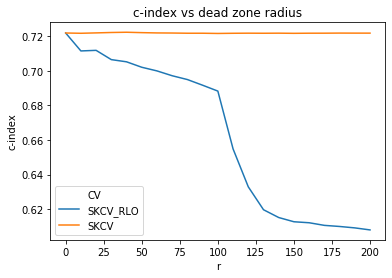

In [195]:
import seaborn as sns

SKCV_RLO = pd.Series(scores_SKCV_RLO)
SKCV = pd.Series(scores_SKCV)
df = pd.concat([SKCV, SKCV_RLO]).reset_index()
df['CV'] = ['SKCV_RLO' for i in range(len(SKCV_RLO))] + ['SKCV' for i in range(len(SKCV))]
df.columns = ['r', 'c-index', 'CV']

sns.lineplot(y='c-index', x='r', hue='CV', size=None, data=df).set_title('c-index vs dead zone radius')

As we see, there is a clear difference between the SKCV_RLO and the SKCV performance results. Increassing the dead zone radius strongly affects negativelly the performance result in the SKCV, while in the SKCV_RLO, removing the same number of data points but randomly does not practically affect to the performace result.

This results confirm, as was discussed above, that using a traditional cross-validation would result in a highly over-optimistic performance result, and that SKCV is a good method to counteract the effect of SAC.
